In [1]:
from __future__ import  absolute_import, division, print_function, unicode_literals
import pickle
import random
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as img
import cv2
import time
from tqdm import tqdm
import sys
import pyprind
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras

from PIL import Image

In [2]:

def get_all_jpeg_files_paths(path):
    returnedFiles = []
    print(os.walk(path))
    for  r,d, files in os.walk(path):
        for file in files:
            if '.jpeg' in file:
                returnedFiles.append(os.path.join(r,file))
    return returnedFiles

In [3]:
train_normal_data_dir = os.path.join('chest_xray','train','NORMAL')
train_normal_data_files = get_all_jpeg_files_paths(train_normal_data_dir) 


<generator object walk at 0x000002914C020E48>


In [4]:
train_pneumonia_data_dir=os.path.join('chest_xray','train','PNEUMONIA')
train_pneumonia_data_files = get_all_jpeg_files_paths(train_pneumonia_data_dir)

<generator object walk at 0x000002914C020F48>


1341
3875
(1152, 1422)


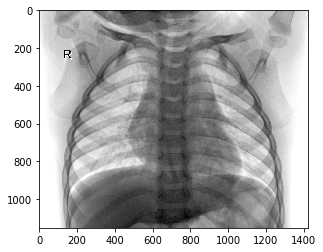

In [5]:
print(len(train_normal_data_files))
print(len(train_pneumonia_data_files))
image = img.imread(train_normal_data_files[1])
pneumonia_image = img.imread(train_pneumonia_data_files[0])
print(image.shape)
plt.imshow(image, cmap="binary")


In [6]:
def find_median_dimensions_from_files(paths_array):
    xAxis = []
    yAxis = []

    for path in pyprind.prog_percent(paths_array):
        image = img.imread(path)
        xAxis.append(image.shape[0])
        yAxis.append(image.shape[1])
    
    return np.median(xAxis), np.median(yAxis)

xAxisMedian, yAxisMedian = find_median_dimensions_from_files(train_normal_data_files)
print(xAxisMedian, yAxisMedian)


[100 %] Time elapsed: 00:02:01 | ETA: 00:00:00

1328.0 1640.0



Total time elapsed: 00:02:01


In [7]:
SIZE = (int(xAxisMedian), int(yAxisMedian))
imageResized = cv2.resize(image, (int(yAxisMedian), int(xAxisMedian)))
print(imageResized.shape)

(1328, 1640)


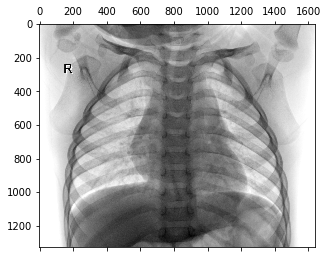

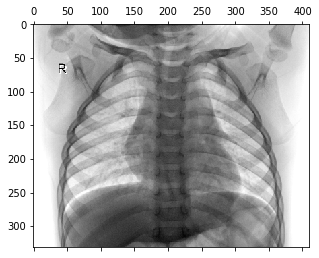

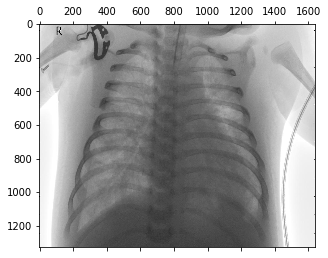

In [8]:
pneumonia_imageResized = cv2.resize(pneumonia_image,(SIZE[1], SIZE[0]))
SIZE = (SIZE[0]//4,SIZE[1]//4)


imageResized_2 = cv2.resize(imageResized, (SIZE[1],SIZE[0]))
pneumonia_image=img.imread(train_pneumonia_data_files[0])
plt.matshow(imageResized, cmap="binary")
plt.matshow(imageResized_2, cmap="binary")
plt.matshow(pneumonia_imageResized, cmap='binary')


In [9]:
train_path = os.path.join('chest_xray','train')
test_path = os.path.join('chest_xray','test')
val_path = os.path.join('chest_xray','val')
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_image_generator = data_gen.flow_from_directory(train_path,target_size=SIZE,shuffle=True,color_mode='grayscale',class_mode='binary')
test_image_generator = data_gen.flow_from_directory(test_path,target_size=SIZE,shuffle=True,color_mode='grayscale',class_mode='binary')
val_image_generator = data_gen.flow_from_directory(val_path,target_size=SIZE,shuffle=True,color_mode='grayscale',class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
print(SIZE)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights',
                                                 save_weights_only=True,
                                                 verbose=1)

(332, 410)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model=Sequential([
    keras.layers.Conv2D(8, (3,1), padding='same', activation='relu', input_shape=(SIZE[0],SIZE[1],1)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(8,(3,1), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16,(3,1), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001),),
    Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001),),
    Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001),),
    Dropout(0.2),
    keras.layers.Dense(64, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001),),
    keras.layers.Dense(1, activation = 'sigmoid')
])





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Recall','Precision'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 332, 410, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 166, 205, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 164, 205, 8)       200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 82, 102, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 102, 16)       400       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 51, 16)        0         
____________________________

In [13]:

history = model.fit(
    train_image_generator,
    steps_per_epoch=20,
    batch_size = 16,
    epochs=25,
    validation_steps=1,
    validation_data=val_image_generator,
    shuffle = True,
    callbacks=[cp_callback]
)

Epoch 1/25
19/20 [===========================>..] - ETA: 2s - loss: 0.8575 - acc: 0.6957 - recall: 0.8429 - precision: 0.7697
Epoch 00001: saving model to weights
20/20 [==============================] - 60s 3s/step - loss: 0.8429 - acc: 0.7016 - recall: 0.8515 - precision: 0.7723 - val_loss: 1.1361 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/25
19/20 [===========================>..] - ETA: 1s - loss: 0.6183 - acc: 0.7845 - recall: 0.9731 - precision: 0.7848
Epoch 00002: saving model to weights
20/20 [==============================] - 70s 4s/step - loss: 0.6102 - acc: 0.7875 - recall: 0.9725 - precision: 0.7887 - val_loss: 1.6920 - val_acc: 0.6250 - val_recall: 1.0000 - val_precision: 0.5714
Epoch 3/25
19/20 [===========================>..] - ETA: 1s - loss: 0.3570 - acc: 0.9194 - recall: 0.9320 - precision: 0.9594
Epoch 00003: saving model to weights
20/20 [==============================] - 40s 2s/step - loss: 0.3549 - acc: 0.9203 - recall: 0.9350 - precisio

Epoch 24/25
19/20 [===========================>..] - ETA: 0s - loss: 0.1632 - acc: 0.9688 - recall: 0.9828 - precision: 0.9765
Epoch 00024: saving model to weights
20/20 [==============================] - 42s 2s/step - loss: 0.1606 - acc: 0.9688 - recall: 0.9836 - precision: 0.9756 - val_loss: 0.1614 - val_acc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 25/25
19/20 [===========================>..] - ETA: 1s - loss: 0.1852 - acc: 0.9622 - recall: 0.9670 - precision: 0.9821
Epoch 00025: saving model to weights
20/20 [==============================] - 32s 2s/step - loss: 0.1888 - acc: 0.9578 - recall: 0.9606 - precision: 0.9830 - val_loss: 0.1602 - val_acc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000


In [19]:
model.save('firstSave.model')

dict_keys(['loss', 'acc', 'recall', 'precision', 'val_loss', 'val_acc', 'val_recall', 'val_precision'])
[0.5, 0.625, 0.625, 0.625, 0.6875, 0.6875, 0.9375, 1.0, 0.625, 0.5625, 0.875, 1.0, 1.0, 0.8125, 0.625, 1.0, 0.875, 0.8125, 0.625, 0.8125, 1.0, 1.0, 0.9375, 1.0, 1.0]


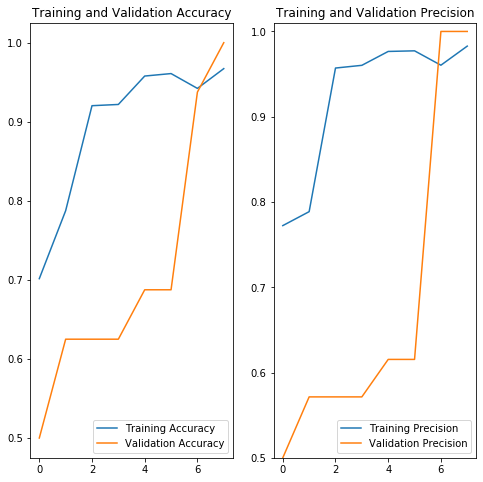

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
print(history.history.keys())
print(val_acc)


precision = history.history['precision']
val_precision = history.history['val_precision']

epochs_range = range(8)
# small valid dataset causes high fluctuations on val_accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:8], label='Training Accuracy')
plt.plot(epochs_range, val_acc[:8], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, precision[:8], label='Training Precision')
plt.plot(epochs_range, val_precision[:8], label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.ylim(top=1.01,bottom=0.5)

plt.show()

In [15]:
test_metrics = model.evaluate(test_image_generator)

20/20 [==============================] - 23s 1s/step - loss: 0.7600 - acc: 0.8317 - recall: 0.9795 - precision: 0.7975


In [20]:
print('accuracy: ',test_metrics[1],'%\n recall: ',test_metrics[2],'%\n precision: ',test_metrics[3],'%')

accuracy:  0.8317308 %
 recall:  0.9794872 %
 precision:  0.79749477 %


In [21]:
!mkdir -p saved_model
model.save('saved_model/my_model') 